# Clasificación de los píxeles de una imagen de carnet

En este cuaderno vamos a abordar un problema de reconocimiento del tipo de los píxeles de una imagen de tipo carnet. Dentro de dichas imágenes se desea distinguir el fondo, la cara, la camiseta y el pelo.

### Exploración de la base de datos

En el directorio "Caras" tenemos una base datos compuesta de 20 imágenes RGB tipo PNG de tipo carnet correspondiente a 20 individuos. Además, también tenemos 20 ficheros PNG de tipo paleta con una etiqueta para cada píxel (PELO=0, CARA=1, CAMISETA=2, FONDO=3). Esta base de datos es la que usaremos para aprender y para testear el sistema.

Cargamos una imagen y las etiquetas correspondientes a cada píxel y las mostramos.

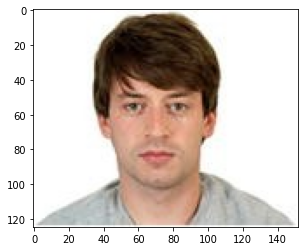

In [1]:
import cv2
from matplotlib import pyplot as plt

rgb_img = cv2.imread("./Caras/01.png")[:,:,::-1]
plt.imshow(rgb_img)
plt.show()

Para cargar las imágenes de las etiquetas usamos el paquete PIL que permite cargar imágenes PNG de paleta.

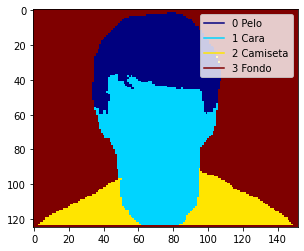

In [2]:
import PIL
from matplotlib import cm
import numpy as np

label_img = PIL.Image.open("./Caras/01_label.png")
label_img = np.array(label_img)
PELO=0;CARA=1;CAMISETA=2;FONDO=3;etiquetas=["Pelo","Cara","Camiseta","Fondo"]

def draw_labeled_image(label_img):
    plt.imshow(label_img,cmap="jet",interpolation="Nearest")    
    NUM_ETIQUETAS = len(etiquetas)
    for x in range(0,NUM_ETIQUETAS):
        plt.plot(0, 0, "-", color=cm.jet(x/(NUM_ETIQUETAS-1)), label=str(x) + " " + etiquetas[x])
    plt.legend(loc="upper right")
    plt.show()
    
draw_labeled_image(label_img)

Ahora, cargamos todas las imagenes y sus etiquetas. Las almacenamos en sendas lista y las mostramos.

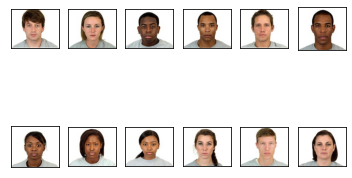

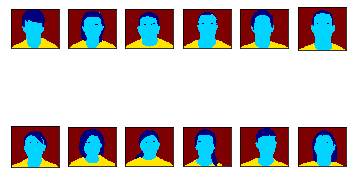

In [3]:
images = []
label_images = []

fig, axes = plt.subplots(2,6)
cont = 1
for ax in axes.reshape(12,):
    rgb_img = cv2.imread(f"./Caras/{cont:02d}.png")[:,:,::-1]
    images.append(rgb_img)
    cont += 1
    ax.imshow(rgb_img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

fig, axes = plt.subplots(2,6)
cont = 1
for ax in axes.reshape(12,):
    label_img = PIL.Image.open(f"./Caras/{cont:02d}_label.png")
    label_img = np.array(label_img)
    label_images.append(label_img)
    cont += 1
    ax.imshow(label_img,cmap="jet",interpolation="Nearest")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Finalmente, separamos las imagenes en un conjunto que usaremos para el aprendizaje y otro que usaremos para probar los modelos que construyamos.

In [4]:
from sklearn import model_selection as ms

x_train, x_test, y_train, y_test = ms.train_test_split(images,label_images,test_size=0.4,random_state=10)

print(type(x_train))
print(len(x_train))
print(type(x_train[0]))
print(x_train[0].shape)


<class 'list'>
7
<class 'numpy.ndarray'>
(125, 152, 3)


## Clasificador euclideo

Creamos un clasificador basado en distancia euclidea usando como caracteristica discriminante de cada píxel su valor RGB.

In [5]:
def extrae_clase(x_train, y_train, clase):
    num_caracteristicas = x_train[0].shape[2]
    output = np.ndarray((0,num_caracteristicas))
    for image,label in zip(x_train,y_train):
        class_pixels = image[label==clase]
        output = np.concatenate((output, class_pixels),axis=0)
    return output    

def obtener_centroides(x_train, y_train):
    num_caracteristicas = x_train[0].shape[2]
    centroides = np.ndarray((4,num_caracteristicas))
    for clase in range(0,4):
        centroides[clase,:] = np.mean(extrae_clase(x_train, y_train, clase),axis=0)
    return centroides

centroides = obtener_centroides(x_train, y_train)
print("Centroides = ",centroides)

Centroides =  [[ 67.10685451  49.66312407  33.63206459]
 [186.34414213 134.22589763 105.78425891]
 [183.09636597 187.26686618 183.52877298]
 [253.74795702 253.64072183 252.97200244]]


Mostramos el resultado de la clasificación sobre un par de imágenes de test.

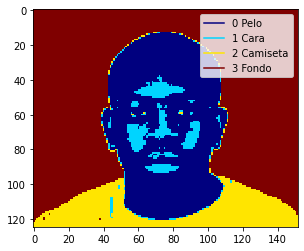

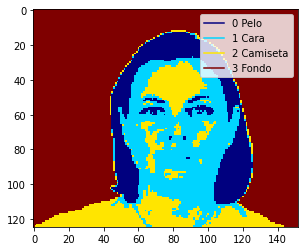

In [6]:
def predict(rgb_points, centroides):
    num_caracteristicas = rgb_points[0].shape[-1]
    x_test_broadcast = rgb_points.reshape(-1,num_caracteristicas,1)
    centroides_broadcast = centroides.transpose()
    distances_by_chanel = (x_test_broadcast - centroides_broadcast)**2
    distances = np.sum(distances_by_chanel,axis=1)
    output = np.argmin(distances,axis=1)
    return output

num_caracteristicas = x_train[0].shape[2]
predicted_test = predict(x_test[0].reshape(-1,num_caracteristicas),centroides)
draw_labeled_image(predicted_test.reshape(y_test[0].shape))
predicted_test = predict(x_test[-1].reshape(-1,num_caracteristicas),centroides)
draw_labeled_image(predicted_test.reshape(y_test[-1].shape))

En la primera imagen, podemos observar que algunos píxeles correspondientes a la cara se han etiquetado como pelo. Esto se debe a que la piel del sujeto es muy oscura comparada con la media de las observadas en la muestra de aprendizaje.

También observamos, en la segunda imagen, que alunos píxeles de la cara se han etiquetado como camiseta.

Finalmente, podemos observar que ambas imágenes tienen un halo entorno a la cabeza que no se han etiquetado correctamente como píxeles de tipo pelo.

Ahora, evaluamos los resultados sobre todo el conjunto de test. Para ello usamos una matriz de confusión de los patrones reconocidos y de los porcentajes. También mostramos la tasa de acierto global (accuracy) obtenido sobre todo el conjunto de test.

Para ello lo primero es obtener todos los píxles de todas las imágenes de test en un mismo vector. Y otro vector para todas las etiquetas correspondientes a esos píxeles.

In [7]:
def extrae_pixeles_y_etiquetas(image_list, label_list):
    num_caracteristicas = image_list[0].shape[-1]

    output_pixels = np.ndarray((0,num_caracteristicas))
    output_labels = np.ndarray((0))
    for image,label in zip(image_list,label_list):
        output_pixels = np.concatenate((output_pixels, image.reshape(-1,num_caracteristicas)),axis=0)
        output_labels = np.concatenate((output_labels,label.reshape(-1)),axis=0)
    return output_pixels, output_labels

x_test_pixels, y_test_labels = extrae_pixeles_y_etiquetas(x_test, y_test)
print(x_test_pixels.shape)
print(y_test_labels.shape)

(92500, 3)
(92500,)


Luego realizamos la predicción de todos los píxeles del conjunto de test.

In [8]:
euclidean_predicted_test = predict(x_test_pixels,centroides)

Finalmente, comparamos los resultados con las etiquetas para obtener el accuracy y las matrices de confusión.

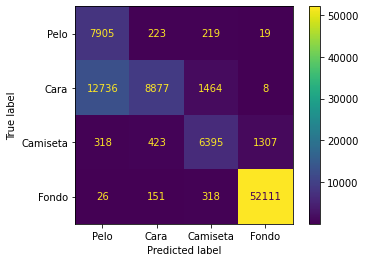

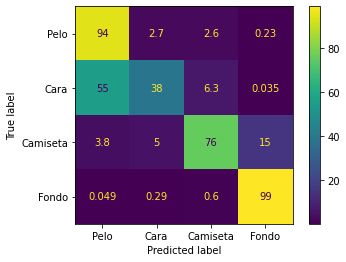

75288 píxeles predichos correctamente de 92500 píxeles totales.
Tasa de acierto: 81.39%


In [9]:
import sklearn.metrics as metrics

def performance_analisys(labels,predictions):
    confusion_matrix = metrics.confusion_matrix(labels,predictions)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=etiquetas)
    disp.plot()
    plt.show()
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=100*confusion_matrix/np.sum(confusion_matrix,axis=1).reshape(4,1), display_labels=etiquetas)
    disp.plot()
    plt.show()
    success = np.sum(labels == predictions)
    print(str(success) + " píxeles predichos correctamente de " + str(labels.shape[0]) + " píxeles totales.")
    accuracy = 100 *success / labels.shape[0]
    print(f"Tasa de acierto: {accuracy:0.2f}%")
    return accuracy


accuracy_eu = performance_analisys(y_test_labels,euclidean_predicted_test)

Podemos observar un 94% de recall respecto a los píxeles de pelo, pero también observamos muchos falsos positivos respecto a píxeles de la cara etiquetados como pelo(55%)  y un recall de píxeles de la cara muy bajo (38%).

## LDA

Aplicamos LDA, y aplicamos el clasificador bayesiano que trae incorporado, volvemos obtener la matriz de confusión.

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)

x_train_points, y_train_points = extrae_pixeles_y_etiquetas(x_train, y_train)

lda.fit(x_train_points, y_train_points)

LinearDiscriminantAnalysis(n_components=2)

Mostramos el resultado sobre un par de imágenes.

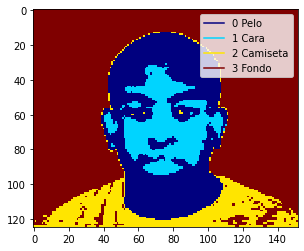

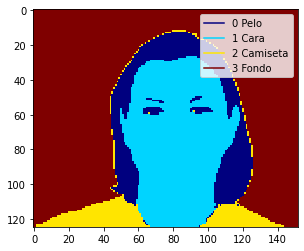

In [11]:
num_caracteristicas = x_test[0].shape[2]
predicted_test_lda = lda.predict(x_test[0].reshape(-1,num_caracteristicas))
draw_labeled_image(predicted_test_lda.reshape(y_test[0].shape))
predicted_test_lda = lda.predict(x_test[-1].reshape(-1,num_caracteristicas))
draw_labeled_image(predicted_test_lda.reshape(y_test[-1].shape))

Podemos observar que mejora el número de píxeles etiquetados como cara tanto en la primera como en la segunda imagen. Sin embargo, el halo se mantiene.

Mostramos la matriz de confusión y el accuracy.

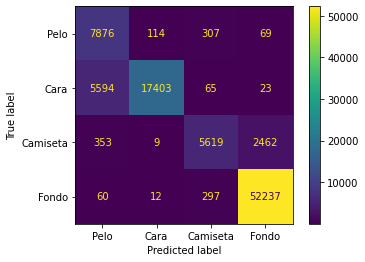

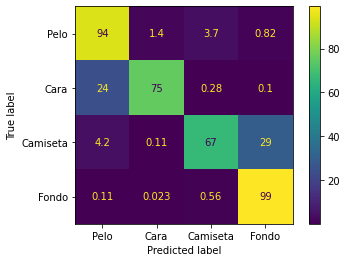

83135 píxeles predichos correctamente de 92500 píxeles totales.
Tasa de acierto: 89.88%


In [12]:
lda_predicted_test = lda.predict(x_test_pixels)
accuracy_lda = performance_analisys(y_test_labels,lda_predicted_test)

Se aprecia que la tasa de falsos positivos respecto a píxeles de la cara etiquetados como pelo se ha reducido, pero sigue teniendo un valor importante del 24%. A la vez, el recall de píxeles de la cara mejora al 75%.

## MLP

Creamos un clasificador basado en MLP, lo aplicamos y volvemos obtener la matriz de confusión

In [13]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=200, verbose=True)
clf.fit(x_train_points, y_train_points)

Iteration 1, loss = 1.24915576
Iteration 2, loss = 0.17117221
Iteration 3, loss = 0.15103409
Iteration 4, loss = 0.17100819
Iteration 5, loss = 0.14791044
Iteration 6, loss = 0.16088442
Iteration 7, loss = 0.13164257
Iteration 8, loss = 0.12765824
Iteration 9, loss = 0.19659108
Iteration 10, loss = 0.13387538
Iteration 11, loss = 0.21094150
Iteration 12, loss = 0.12128204
Iteration 13, loss = 0.11450618
Iteration 14, loss = 0.11229271
Iteration 15, loss = 0.21192943
Iteration 16, loss = 0.11228277
Iteration 17, loss = 0.11608655
Iteration 18, loss = 0.15945824
Iteration 19, loss = 0.10853507
Iteration 20, loss = 0.17674477
Iteration 21, loss = 0.11031171
Iteration 22, loss = 0.10472022
Iteration 23, loss = 0.23059536
Iteration 24, loss = 0.10529277
Iteration 25, loss = 0.10774030
Iteration 26, loss = 0.10540779
Iteration 27, loss = 0.11057301
Iteration 28, loss = 0.13930436
Iteration 29, loss = 0.10383084
Iteration 30, loss = 0.10422907
Iteration 31, loss = 0.22344921
Iteration 32, los

MLPClassifier(random_state=1, verbose=True)

Mostramos el resultado sobre un par de imágenes.

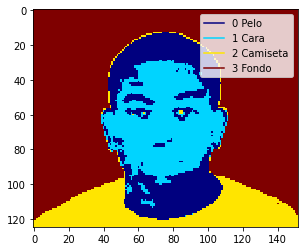

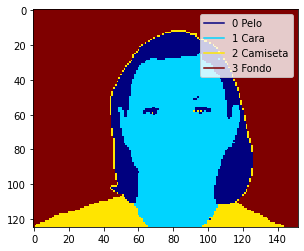

In [14]:
num_caracteristicas = x_test[0].shape[2]
predicted_test_mlp = clf.predict(x_test[0].reshape(-1,num_caracteristicas))
draw_labeled_image(predicted_test_mlp.reshape(y_test[0].shape))

predicted_test_mlp = clf.predict(x_test[-1].reshape(-1,num_caracteristicas))
draw_labeled_image(predicted_test_mlp.reshape(y_test[-1].shape))

In [15]:
mlp_prediction = clf.predict(x_test_pixels)
print(mlp_prediction.shape)

(92500,)


Vemos que en la primera imagen los píxeles de la cara siguen aumentando, aunque el halo se mantiene.

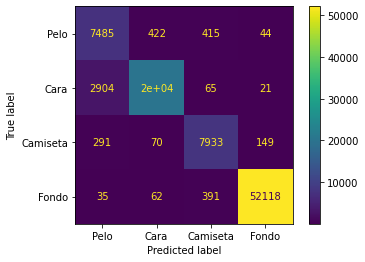

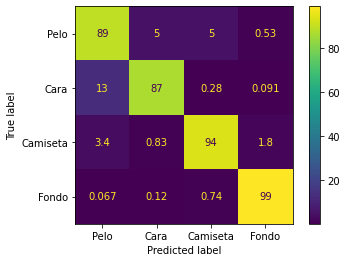

87631 píxeles predichos correctamente de 92500 píxeles totales.
Tasa de acierto: 94.74%


In [16]:
accuracy_mlp = performance_analisys(y_test_labels,mlp_prediction)

Se aprecia que la tasa de falsos positivos respecto a píxeles de la cara etiquetados como pelo se ha reducido aún más (!4%). A la vez, el recall de píxeles de la cara mejora al 86%. Por contra, el recall de pelo empeora un poco respecto a LDA.


## Añadiendo más características para clasificar cada píxel

Con objeto de seguir mejorando los resultados planteamos añadir nuevas características discriminantes a cada píxel.

Así, además de los valores R, G y B, añadimos como característica a cada píxel la posición en X e Y de dicho píxel y el valor medio de brillo de la imagen.

La idea es que:
- Las coordenadas sirvan para que un píxel demasiado alto en la imagen (los halos o la cara) no se clasifique como camiseta.
- El tono más oscuro de la piel influya en la media de la imagen y ayude a clasificar correctamente los píxeles que aún faltan.

In [17]:
def añade_nuevas_caracteristicas(image_list):
    new_image_list = []
    for image in image_list:
        media = np.mean(image)
        new_image = np.ndarray((image.shape[0],image.shape[1],image.shape[2]+3),dtype=np.uint8)
        for y in range(0,image.shape[0]):
            for x in range(0,image.shape[1]):
                new_features = np.array([x,y,media],dtype=np.uint8)
                new_image[y,x] = np.concatenate((image[y,x],new_features))
        new_image_list.append(new_image)
    return new_image_list

new_x_train = añade_nuevas_caracteristicas(x_train)
new_x_test = añade_nuevas_caracteristicas(x_test)

print(len(new_x_train))
print(len(new_x_test))

print(new_x_train[0].shape)
print(new_x_test[0].shape)

7
5
(125, 152, 6)
(125, 152, 6)


## Euclideo con nuevas características

Usando el nuevo vector de características ampliado, volvemos a crear un clasificador euclideo, volvemos obtener la matriz de confusión.

In [18]:
new_centroids = obtener_centroides(new_x_train, y_train)
print(new_centroids)

[[ 67.10685451  49.66312407  33.63206459  74.13255891  37.38589553
  200.91489537]
 [186.34414213 134.22589763 105.78425891  75.28873152  73.05208722
  201.32236924]
 [183.09636597 187.26686618 183.52877298  75.46985891 115.38477982
  201.27943566]
 [253.74795702 253.64072183 252.97200244  75.80859025  53.14728924
  201.57665874]]


Volvemos a mostrar el resultado sobre un par de imágenes.

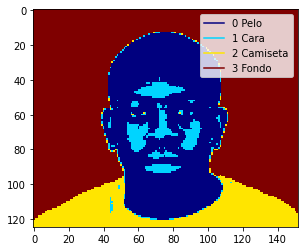

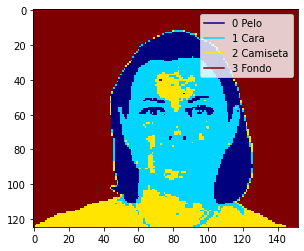

In [19]:

num_caracteristicas = new_x_train[0].shape[2]
predicted_test = predict(new_x_test[0].reshape(-1,num_caracteristicas),new_centroids)
draw_labeled_image(predicted_test.reshape(y_test[0].shape))
predicted_test = predict(new_x_test[-1].reshape(-1,num_caracteristicas),new_centroids)
draw_labeled_image(predicted_test.reshape(y_test[-1].shape))

Observamos que los resultados mejoran respecto al clasificador euclideo que solo usaba los valores RGB de cada píxel para clasificarlo.

Ahora revisamos el resultado sobre todo el conjunto de test.

(92500, 6)
(92500,)


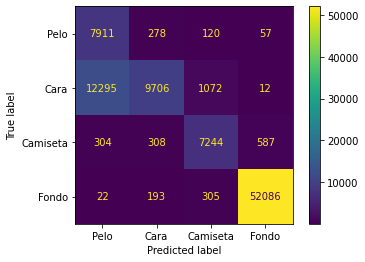

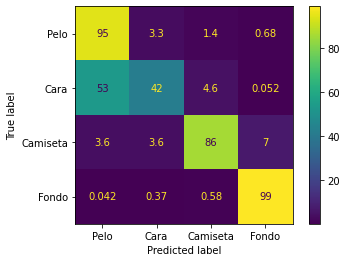

76947 píxeles predichos correctamente de 92500 píxeles totales.
Tasa de acierto: 83.19%


In [20]:
new_x_test_pixels, new_y_test_labels = extrae_pixeles_y_etiquetas(new_x_test, y_test)
print(new_x_test_pixels.shape)
print(new_y_test_labels.shape)

euclidean_new_predicted_test = predict(new_x_test_pixels,new_centroids)

accuracy_new_eu = performance_analisys(y_test_labels,euclidean_new_predicted_test)

Se confirma que los resultados mejoran los obtenidos cuando usabamos solo el valor RGB de cada píxel como vector de caracterísrticas.

## LDA con nueva características

Con los nuevos vectores de características, volvemos a crear un clasificador usando LDA y el clasificador Bayes que trae incluido. Luego volvemos obtener la matriz de confusión.

In [21]:
new_x_train_points, y_train_points = extrae_pixeles_y_etiquetas(new_x_train, y_train)

new_lda = LinearDiscriminantAnalysis(n_components=3)
new_lda.fit(new_x_train_points, y_train_points)

LinearDiscriminantAnalysis(n_components=3)

Volvemos a mostrar el resultado sobre un par de imágenes.

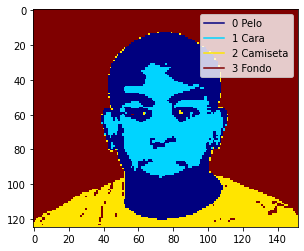

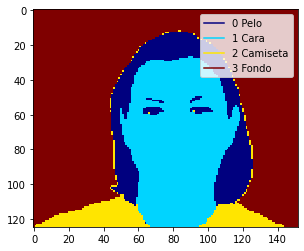

In [22]:
num_caracteristicas = new_x_train[0].shape[2]
predicted_test = new_lda.predict(new_x_test[0].reshape(-1,num_caracteristicas))
draw_labeled_image(predicted_test.reshape(y_test[0].shape))
predicted_test = new_lda.predict(new_x_test[-1].reshape(-1,num_caracteristicas))
draw_labeled_image(predicted_test.reshape(y_test[-1].shape))

De nuevo vemos que, los resultados sobre el par de imágenes que va,os probando mejoran los resultados anteriores.

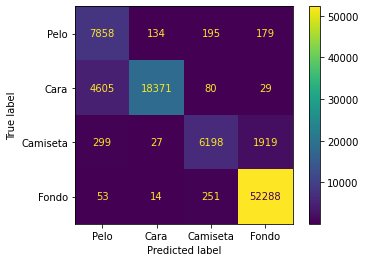

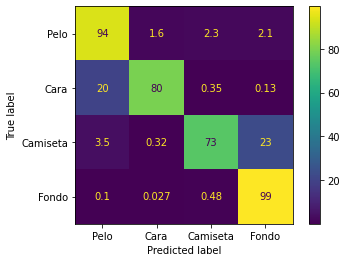

84715 píxeles predichos correctamente de 92500 píxeles totales.
Tasa de acierto: 91.58%


In [23]:
new_lda_predicted_test = new_lda.predict(new_x_test_pixels)

accuracy_new_lda = performance_analisys(y_test_labels,new_lda_predicted_test)

Se confirma esta mejora sobre los resultados de todo el conjunto de test.

## MLP con nuevas características

Volvemos a crear un clasificador basado en MLP sobre y volvemos obtener la matriz de confusión

In [24]:
new_clf = MLPClassifier(random_state=1, max_iter=200, verbose=True)
new_clf.fit(new_x_train_points, y_train_points)

Iteration 1, loss = 0.19148987
Iteration 2, loss = 0.07794499
Iteration 3, loss = 0.07701541
Iteration 4, loss = 0.07284261
Iteration 5, loss = 0.07384352
Iteration 6, loss = 0.07639693
Iteration 7, loss = 0.07019167
Iteration 8, loss = 0.07091399
Iteration 9, loss = 0.06932427
Iteration 10, loss = 0.06914529
Iteration 11, loss = 0.06993727
Iteration 12, loss = 0.06526043
Iteration 13, loss = 0.06760468
Iteration 14, loss = 0.06466028
Iteration 15, loss = 0.06202250
Iteration 16, loss = 0.06189490
Iteration 17, loss = 0.06024494
Iteration 18, loss = 0.05877784
Iteration 19, loss = 0.06101564
Iteration 20, loss = 0.05923832
Iteration 21, loss = 0.05819105
Iteration 22, loss = 0.05613245
Iteration 23, loss = 0.05537777
Iteration 24, loss = 0.05581834
Iteration 25, loss = 0.05559044
Iteration 26, loss = 0.05520995
Iteration 27, loss = 0.05335092
Iteration 28, loss = 0.05436955
Iteration 29, loss = 0.05196096
Iteration 30, loss = 0.05199218
Iteration 31, loss = 0.05175389
Iteration 32, los

MLPClassifier(random_state=1, verbose=True)

Volvemos a mostrar el resultado sobre un par de imágenes.

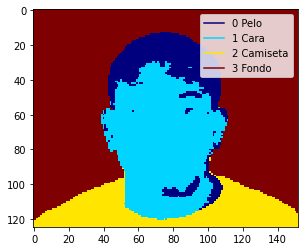

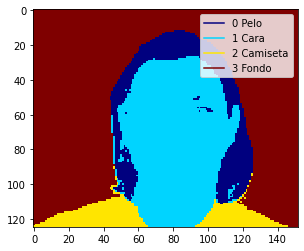

In [25]:
predicted_test_mlp = new_clf.predict(new_x_test[0].reshape(-1,num_caracteristicas))
draw_labeled_image(predicted_test_mlp.reshape(y_test[0].shape))
predicted_test_mlp = new_clf.predict(new_x_test[-1].reshape(-1,num_caracteristicas))
draw_labeled_image(predicted_test_mlp.reshape(y_test[-1].shape))

En ambas imágenes se aprecia que los halos han desaparecido. Además, en la primera imagen, la mayor parte de los píxeles de la cara por fin se han clasificado correctamente.

Analicemos todo el conjunto de test a ver si esta mejora se confirma.

(92500,)


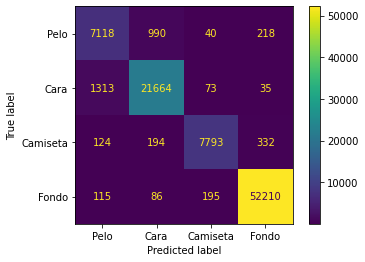

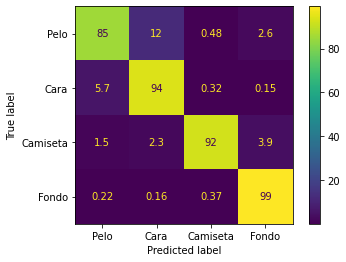

88785 píxeles predichos correctamente de 92500 píxeles totales.
Tasa de acierto: 95.98%


In [26]:
new_mlp_prediction = new_clf.predict(new_x_test_pixels)
print(new_mlp_prediction.shape)

accuracy_new_mlp = performance_analisys(y_test_labels,new_mlp_prediction)

Tanto en las matrices de confusión, como en la medida de accuracy se aprecia que los resultado son los mejores hasta el momento.

## Resumen
La siguiente tabla resume los resultados obtenidos en las diferentes pruebas.

In [27]:
from IPython.display import Markdown as md

text = "| Method | Accuracy |\n"
text += "|--------|----------|\n"
text += f"|Euclideo (R, G, B)| {accuracy_eu:0.2f}%|\n"
text += f"|LDA y Bayes (R, G, B)| {accuracy_lda:0.2f}%|\n"
text += f"|MLP (R, G, B)| {accuracy_mlp:0.2f}%|\n"
text += f"|Euclideo (R, G, B, x, y, brillo)| {accuracy_new_eu:0.2f}%|\n"
text += f"|LDA y Bayes (R, G, B, x, y, brillo)| {accuracy_new_lda:0.2f}%|\n"
text += f"|MLP (R, G, B, x, y, brillo) |{accuracy_new_mlp:0.2f}%|\n"

md(text)

| Method | Accuracy |
|--------|----------|
|Euclideo (R, G, B)| 81.39%|
|LDA y Bayes (R, G, B)| 89.88%|
|MLP (R, G, B)| 94.74%|
|Euclideo (R, G, B, x, y, brillo)| 83.19%|
|LDA y Bayes (R, G, B, x, y, brillo)| 91.58%|
|MLP (R, G, B, x, y, brillo) |95.98%|
